# Some preprocessing to implement tanh in generator

In [1]:
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')
!ls
%cd gdrive/My\ Drive/GANs_for_Tabular_data-master/cWGAN_GP/
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data
/content/gdrive/My Drive/GANs_for_Tabular_data-master/cWGAN_GP
 cWGAN_GP.ipynb			'lung cancer-name.csv'
 cWGAN_GP-lung2.ipynb		'pancreatic2020 data.csv'
 cWGAN_GP-lung.ipynb		'Parkinsson disease.csv'
 cWGAN_GP-pancreatic.ipynb	 Prostate_Cancer.csv
 cWGAN_GP-parkinson.ipynb	'survey lung cancer.csv'
 cWGAN_GP-prostateCancer.ipynb	 train.csv
'lung cancer2.csv'


In [2]:
#!pip list
#!pip install lightgbm==3.3.4 --upgrade 
#!pip install xgboost --upgrade
!pip install xgboost==1.6.2 --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


# normalized_df=(df-df.mean())/df.std()
df = pd.read_csv('Prostate_Cancer.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    int64  
 1   diagnosis_result   100 non-null    object 
 2   radius             100 non-null    int64  
 3   texture            100 non-null    int64  
 4   perimeter          100 non-null    int64  
 5   area               100 non-null    int64  
 6   smoothness         100 non-null    float64
 7   compactness        100 non-null    float64
 8   symmetry           100 non-null    float64
 9   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 7.9+ KB


In [4]:
df.describe()

,id,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,16.850000,18.230000,96.780000,702.880000,0.102730,0.126700,0.193170,0.064690
std,29.011492,4.879094,5.192954,23.676089,319.710895,0.014642,0.061144,0.030785,0.008151
min,1.000000,9.000000,11.000000,52.000000,202.000000,0.070000,0.038000,0.135000,0.053000
25%,25.750000,12.000000,14.000000,82.500000,476.750000,0.093500,0.080500,0.172000,0.059000
50%,50.500000,17.000000,17.500000,94.000000,644.000000,0.102000,0.118500,0.190000,0.063000
75%,75.250000,21.000000,22.250000,114.250000,917.000000,0.112000,0.157000,0.209000,0.069000
max,100.000000,25.000000,27.000000,172.000000,1878.000000,0.143000,0.345000,0.304000,0.097000


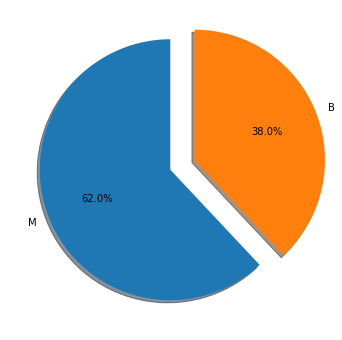

In [5]:
df = df.drop(['id'], axis=1)
data_dr = df['diagnosis_result'].value_counts()

label = [data_dr.index.tolist()]
plt.pie(data_dr, labels=label[0], shadow=True, explode=(0.0, 0.2), autopct='%1.1f%%', startangle=90)
plt.gcf().set_size_inches(12,6)
plt.show()

In [6]:
df['diagnosis_result'].replace({'M':0,'B':1},inplace=True)

In [7]:
# Data correlation matrix
# corr_metrics = df.corr()
# corr_metrics.style.background_gradient()

In [8]:
df = df.drop(['fractal_dimension', 'texture', 'perimeter'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   diagnosis_result  100 non-null    int64  
 1   radius            100 non-null    int64  
 2   area              100 non-null    int64  
 3   smoothness        100 non-null    float64
 4   compactness       100 non-null    float64
 5   symmetry          100 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 4.8 KB


In [9]:
# split the data in train and test function

from sklearn.model_selection import train_test_split

X = df.drop(['diagnosis_result'], axis=1) # Features
y = df['diagnosis_result'] # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#data =data.drop(['diagnosis_result'], axis=1) # Features

#sc = MinMaxScaler(feature_range=(0, 1))
sc = StandardScaler()
#df_scaled = sc.fit_transform(df)

X_train = sc.fit_transform(X_train)
print(X_train[0:5])
X_test = sc.transform(X_test)

[[-1.17378396  1.16345216 -0.9169247   1.36131503  1.22422202]
 [-0.15689191  0.17367516  0.03776807  0.32571053  0.19414766]
 [ 1.67351376 -1.03938488 -0.47629727 -1.05509546  0.4599733 ]
 [ 1.67351376 -1.05604779 -1.50442793 -1.44961146 -0.23781901]
 [-1.37716236  0.38362785 -0.54973517 -0.03592914 -0.1381344 ]]


              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.82      0.78      0.80        18

    accuracy                           0.77        30
   macro avg       0.76      0.76      0.76        30
weighted avg       0.77      0.77      0.77        30

                   pre       rec       spe        f1       geo       iba       sup

          0       0.69      0.75      0.78      0.72      0.76      0.58        12
          1       0.82      0.78      0.75      0.80      0.76      0.58        18

avg / total       0.77      0.77      0.76      0.77      0.76      0.58        30



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


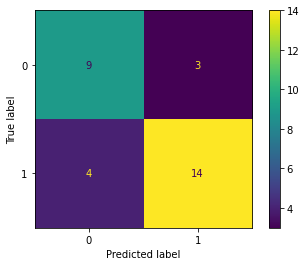

In [11]:
import xgboost as xgb
from sklearn.metrics import classification_report,\
                            plot_confusion_matrix, confusion_matrix
xgb_2=xgb.XGBClassifier()

xgb_2.fit(X_train,y_train)

y_pred = xgb_2.predict(X_test)
#from sklearn.preprocessing import LabelEncoder
#change y value to 0..2
#le2 = LabelEncoder()
#y_test = le2.fit_transform(y_test)



plot_confusion_matrix(xgb_2, X_test, y_test)
print(classification_report(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred)) 

plt.show()


In [12]:
from sklearn.model_selection import KFold, GridSearchCV
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), param_grid = parameter, 
                             scoring='accuracy', n_jobs=-1, cv=2)

p_grid_search.fit(X_train,y_train)


GridSearchCV(cv=2,
             estimator=xgb.XGBClassifier(base_score=None, booster=None,   #leon  add xgb before xgbclassifier
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=None, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),  #3,10,2
                         'min_child_weight': range(1, 5, 2)},  #1,5,2
             scoring='accuracy')

p_grid_search.best_params_, p_grid_search.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.8428571428571429)

              precision    recall  f1-score   support

           0       0.40      1.00      0.57        12
           1       0.00      0.00      0.00        18

    accuracy                           0.40        30
   macro avg       0.20      0.50      0.29        30
weighted avg       0.16      0.40      0.23        30

                   pre       rec       spe        f1       geo       iba       sup

          0       0.40      1.00      0.00      0.57      0.00      0.00        12
          1       0.00      0.00      1.00      0.00      0.00      0.00        18

avg / total       0.16      0.40      0.60      0.23      0.00      0.00        30



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l

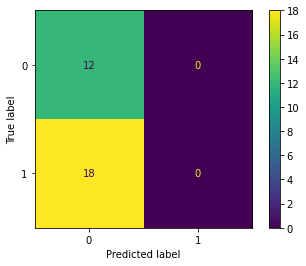

In [13]:
refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                                      min_child_weight=list(p_grid_search.best_params_.values())[-1]+4)
refined_xgb_model.fit(X_train,y_train)
ref_xgb_pred = refined_xgb_model.predict(X_test)
# def plot_confusion_matrix(y_test, y_pred, color):
    
#     plt.rcParams['figure.figsize'] = (16, 9)
   
#     data = {'y_Actual': y_test, 'y_Predicted': y_pred}

#     df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
#     conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
#                               rownames=['Actual'], 
#                               colnames=['Predicted'])
    
#     sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap=color)
#     plt.show()
    
#plot_confusion_matrix(np.array(y_test), ref_xgb_pred, 'crest')
plot_confusion_matrix(refined_xgb_model, X_test, y_test)

print(classification_report(y_test, ref_xgb_pred))
print(classification_report_imbalanced(y_test, ref_xgb_pred))  #, digits=4

WGAN-GP

# Importing the dependencies

In [14]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix

# Creating pytorch dataset and dataloader

In [15]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [16]:
#df = pd.read_csv('lung cancer-name.csv')
#df.info()

#x = df.iloc[:, 0:7].values
#y = df.iloc[:, -1].values

# y= df["LUNG_CANCER"]
# x = df.drop(["LUNG_CANCER"], axis=1)
# print(x.head())
# print(y.head())

# mc = MinMaxScaler(feature_range=(0, 1))
# standard_scaler = mc.fit(x)
# x_scaled = standard_scaler.transform(x)
# x_scaled = pd.DataFrame(x_scaled)

# print(x_scaled.head())
# print(f"y value_count:\n {y.value_counts()}")
# #x_scaled = x_scaled.values
# #y = y.values

# X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.30, shuffle=True)   #7:3

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Number of classes {len(np.unique(y_train))}")




X_train shape: (70, 5)
X_test shape: (30, 5)
y_train shape: (70,)
y_test shape: (30,)
Number of classes 2


In [17]:
#leon
"""
import xgboost as xgb
xgb = xgb.XGBClassifier()
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(xgb, X_test, y_test)
plt.show()
"""

'\nimport xgboost as xgb\nxgb = xgb.XGBClassifier()\nxgb.fit(X_train,y_train)\n\ny_pred = xgb.predict(X_test)\n\nprint(classification_report(y_test, y_pred))\nplot_confusion_matrix(xgb, X_test, y_test)\nplt.show()\n'

In [18]:
# import xgboost as xgb
# parameter = {
#     'max_depth':range(3,10,2), 
#     'min_child_weight':range(1,5,2)
#     }

# p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), param_grid = parameter, 
#                              scoring='accuracy', n_jobs=-1, cv=2)

# p_grid_search.fit(X_train, y_train)


# GridSearchCV(cv=2,
#              estimator=xgb.XGBClassifier(base_score=None, booster=None,   #leon  add xgb before xgbclassifier
#                                      callbacks=None, colsample_bylevel=None,
#                                      colsample_bynode=None,
#                                      colsample_bytree=None,
#                                      early_stopping_rounds=None,
#                                      enable_categorical=False,
#                                      eval_metric='mlogloss', gamma=None,
#                                      gpu_id=None, grow_policy=None,
#                                      importance_type=None,
#                                      interaction_constraints=None,
#                                      learning_rate=None, max_bin=None,
#                                      max_cat_to_onehot=None,
#                                      max_delta_step=None, max_depth=None,
#                                      max_leaves=None, min_child_weight=None,
#                                      missing=None, monotone_constraints=None,
#                                      n_estimators=100, n_jobs=None,
#                                      num_parallel_tree=None, predictor=None,
#                                      random_state=None, reg_alpha=None,
#                                      reg_lambda=None),
#              n_jobs=-1,
#              param_grid={'max_depth': range(3, 10, 2),
#                          'min_child_weight': range(1, 5, 2)},
#              scoring='accuracy')

# p_grid_search.best_params_, p_grid_search.best_score_

In [19]:
# refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', max_depth=list(p_grid_search.best_params_.values())[0]-1, 
#                                       min_child_weight=list(p_grid_search.best_params_.values())[-1]+4)
# refined_xgb_model.fit(X_train, y_train)
# #print(f'Accuracy of XGB classifier on training set: {refined_xgb_model.score(X_train, y_train)}')
# #print(f'Accuracy of XGB classifier on test set: {refined_xgb_model.score(X_test[X_train.columns], y_test)}')

In [20]:
# from imblearn.metrics import classification_report_imbalanced
# ref_xgb_pred_y = refined_xgb_model.predict(X_test)
# def plot_confusion_matrix(y_test, y_pred, color):
    
#     plt.rcParams['figure.figsize'] = (16, 9)
   
#     data = {'y_Actual': y_test, 'y_Predicted': y_pred}

#     df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
#     conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
#                               rownames=['Actual'], 
#                               colnames=['Predicted'])
    
#     sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap=color)
#     plt.show()
    
# plot_confusion_matrix(np.array(y_test), ref_xgb_pred_y, 'crest')
# print(classification_report(y_test, ref_xgb_pred_y))
# print(classification_report_imbalanced(y_test, ref_xgb_pred_y))  #, digits=4

In [21]:
"""
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf, X_test, y_test)
plt.show()
"""

'\nfrom sklearn.ensemble import RandomForestClassifier\nrf = RandomForestClassifier(n_estimators=300, n_jobs=-1)\nrf.fit(X_train,y_train)\ny_pred = rf.predict(X_test)\n\nprint(classification_report(y_test, y_pred))\nplot_confusion_matrix(rf, X_test, y_test)\nplt.show()\n'

Training confusion matrix
[[49  1]
 [ 3 17]]
Testing confusion matrix
[[ 9  3]
 [ 3 15]]
0.9428571428571428
0.8
Train set:70
Train Accuracy=94.28571428571428%
Test set:30
Test Accuracy=80.0%
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.83      0.83      0.83        18

    accuracy                           0.80        30
   macro avg       0.79      0.79      0.79        30
weighted avg       0.80      0.80      0.80        30

                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.75      0.83      0.75      0.79      0.62        12
          1       0.83      0.83      0.75      0.83      0.79      0.63        18

avg / total       0.80      0.80      0.78      0.80      0.79      0.63        30



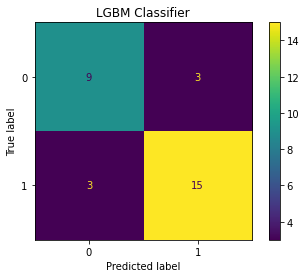

In [22]:
import lightgbm as lgb
lgb_model= lgb.LGBMClassifier()
lgb_model.fit(X_train,y_train)

#from sklearn.metrics import accuracy_score, confusion_matrix
predictions= lgb_model.predict(X_train)
percentage=lgb_model.score(X_train,y_train)
res=confusion_matrix(y_train,predictions)
print("Training confusion matrix")
print(res)
predictions= lgb_model.predict(X_test)
train_percentage=lgb_model.score(X_train,y_train)
test_percentage=lgb_model.score(X_test,y_test)
res = confusion_matrix(y_test,predictions)
print("Testing confusion matrix")
print(res)

# check the accuracy on the training set
print(lgb_model.score(X_train, y_train))
print(lgb_model.score(X_test, y_test))
print(f"Train set:{len(X_train)}")
print(f"Train Accuracy={train_percentage*100}%")
print(f"Test set:{len(X_test)}")
print(f"Test Accuracy={test_percentage*100}%")

print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions)) 
"""
plot_confusion_matrix(lgb_model, X_test, y_test)
plt.show()
"""
cm = confusion_matrix(y_test, predictions, labels=lgb_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_model.classes_)
disp.plot()
_ = disp.ax_.set_title("LGBM Classifier")
plt.show()

In [23]:
class MyDataset(Dataset):
 
  def __init__(self ,x, y):
    """
    df = pd.read_csv('train.csv')
    df["label"] = df.Survived
#     df = df[df['label'] == 1].reset_index(drop = True)
    df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
    median_age = df.Age.median()
    mode_embarked = df.Embarked.mode()[0]
    df = df.fillna({"Age": median_age, "Embarked": mode_embarked})
    df.Sex = df.Sex.replace({'male':0,'female':1})
    df.Embarked = df.Embarked.replace({'S':0,'C':1,'Q':2})
    """
    
    
    """
    mc = MinMaxScaler(feature_range=(0, 1))
    standard_scaler = mc.fit(x)
    x_scaled = standard_scaler.transform(x)

    x_scaled = pd.DataFrame(x_scaled)
    print(x_scaled.head())
    print(f"y value_count:\n {y.value_counts()}")
    x_scaled = x_scaled.values
    y = y.values
    """
    #x = x.values  leon: x is already transformed into narray
    y = y.values

    #X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.20, shuffle=True)
    
    #x = x.values
    #y = y.values
    #X_train = X_train.values
    #y_train = y_train.values
    #self.x_train=torch.tensor(x_scaled,dtype=torch.float32)
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.int)

    print(self.x_train[0:5])
    print(self.y_train[0:5])

  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

train_ds = MyDataset(X_train, y_train)

tensor([[-1.1738,  1.1635, -0.9169,  1.3613,  1.2242],
        [-0.1569,  0.1737,  0.0378,  0.3257,  0.1941],
        [ 1.6735, -1.0394, -0.4763, -1.0551,  0.4600],
        [ 1.6735, -1.0560, -1.5044, -1.4496, -0.2378],
        [-1.3772,  0.3836, -0.5497, -0.0359, -0.1381]])
tensor([0, 0, 1, 1, 0], dtype=torch.int32)


In [24]:
#train_ds.info()

In [25]:
batch_size = 32


train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [27]:
train_dl = DeviceDataLoader(train_dl, device)

In [28]:
train_dl.device

device(type='cuda')

# Creating generator and discriminator models

<b> Generator Architecture

In [29]:
latent_size = 5 # origin is 7 equal to columns
n_features = 5  # equal to columns
num_classes = 2
embed_size = 2  # classes number?

In [30]:
class Generator(nn.Module):
    def __init__(self, embed_size = 2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features + embed_size, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            #nn.Linear(32, 7),
            nn.Linear(32, 5)   # the last number is equal to columns
            
#             nn.Linear(latent_size, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(512, 256),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(256, 128),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(128, 64),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(64, 32),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(32, 16),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(16, 7),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def forward(self, x, labels):
        embed = self.embed(labels)#.reshape(labels.shape[0], 1)
        x = torch.cat([x, embed], dim = 1)
        output = self.model(x)
        return output
    

generator = to_device(Generator(), device)

<b> Discriminator Architecture

In [31]:
class Discriminator(nn.Module):
    def __init__(self, embed_size = 2):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(n_features + embed_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
#             nn.Linear(n_features, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(512, 256),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(256, 128),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(128, 64),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(64, 32),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(32, 16),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(16, 1),
#             nn.Sigmoid()
        )
        
        self.embed = nn.Embedding(num_classes, embed_size)

    def forward(self, x, labels):
        embed = self.embed(labels) #.reshape(labels.shape[0], 1)
        x = torch.cat([x, embed], dim = 1)
        output = self.model(x)
        return output
    
discriminator = to_device(Discriminator(), device)

In [32]:
# for arr, labels in train_dl:
#     break
# # nn.Embedding(2, 2).to('cuda')(labels)#.reshape(labels.shape[0], 1)

# Generator and discriminator training methodology

In [33]:
CRITIC_ITERATIONS = 5
# WEIGHT_CLIP = 0.01
LAMBDA_GP = 10

In [34]:
def gradient_penalty(real_data, generated_data, real_labels,device = device):
    BATCH_SIZE, features_count = real_data.shape
    epsilon = torch.rand((BATCH_SIZE, features_count)).to(device)
    epsilon = epsilon.to(device)

    interpolated_data = real_data * epsilon + generated_data * (1 - epsilon)


    # lets calculate critics score
    mixed_scores = discriminator(interpolated_data, real_labels)

    # Computes and returns the sum of gradients of outputs with respect to the inputs.
    # https://pytorch.org/docs/stable/generated/torch.ones_like.html
    # l2 norm : https://www.analyticsvidhya.com/blog/2021/03/must-known-vector-norms-in-machine-learning/
    gradient = torch.autograd.grad(
      inputs = interpolated_data,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores)
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim = 1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [35]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(real_data, opt_d, cur_batch_size, real_labels):
    # Reset gradients
    opt_d.zero_grad()
    
    real_labels = real_labels.to(device)
    real_preds = discriminator(real_data, real_labels).reshape(-1)

    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_size),  device = device)
    
    generated_data = generator(latent_space_samples, real_labels)  # fake data generated by generator
    fake_preds = discriminator(generated_data, real_labels).reshape(-1)
    
    # calculating gradient penalty
    gp = gradient_penalty(real_data, generated_data, real_labels,device = device)
    
    loss = -(torch.mean(real_preds) - torch.mean(fake_preds)) + LAMBDA_GP * gp

    # Compute gradients
    loss.backward()
    # Adjust the parameters using backprop
    opt_d.step()
        
    return loss

In [36]:
def train_generator(opt_g, cur_batch_size, real_labels):
    # Clear generator gradients
    opt_g.zero_grad()
     
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_size),  device = device)
    generated_data = generator(latent_space_samples, real_labels)  # fake data generated by generator
    fake_preds = discriminator(generated_data, real_labels.to(device)).reshape(-1)
    g_loss = -torch.mean(fake_preds)

    g_loss.backward()
    opt_g.step()
    return g_loss

# Training Loop

In [37]:
lr = 0.001
epochs = 1000  #leon

In [38]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (0.5, 0.9))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas = (0.5, 0.9))

In [39]:
def fit(epochs, lr, opt_d, opt_g):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []

    
    # Create optimizers
#     opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
#     opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    total_step = len(train_dl)
    for epoch in range(epochs):
        for i, (real_data, real_labels) in enumerate(train_dl):
            cur_batch_size = real_data.shape[0]
            
            for _ in range(CRITIC_ITERATIONS):            
                # Train the discriminator and generator
                d_loss = train_discriminator(real_data, opt_d, cur_batch_size, real_labels)            
                
            g_loss = train_generator(opt_g, cur_batch_size, real_labels)
            
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch, epochs, i+1, total_step, d_loss.item(), g_loss.item()))
        # Loss of last batch
        losses_d.append(d_loss.item())
        losses_g.append(g_loss.item())
    return losses_g, losses_d

In [40]:
%%time

history = fit(epochs, lr, opt_d, opt_g)

Epoch [0/1000], Step [1/3], d_loss: 9.4561, g_loss: -0.4848
Epoch [0/1000], Step [2/3], d_loss: 8.6308, g_loss: -0.5040
Epoch [0/1000], Step [3/3], d_loss: 7.0577, g_loss: -0.4675
Epoch [1/1000], Step [1/3], d_loss: 6.1444, g_loss: -0.4200
Epoch [1/1000], Step [2/3], d_loss: 4.2189, g_loss: -0.3295
Epoch [1/1000], Step [3/3], d_loss: 1.5359, g_loss: -0.3218
Epoch [2/1000], Step [1/3], d_loss: 2.9977, g_loss: -0.1950
Epoch [2/1000], Step [2/3], d_loss: 3.0629, g_loss: -0.1531
Epoch [2/1000], Step [3/3], d_loss: 3.1460, g_loss: -0.0522
Epoch [3/1000], Step [1/3], d_loss: 3.9243, g_loss: -0.0850
Epoch [3/1000], Step [2/3], d_loss: 4.5210, g_loss: -0.0469
Epoch [3/1000], Step [3/3], d_loss: 9.0559, g_loss: -0.0219
Epoch [4/1000], Step [1/3], d_loss: 7.3924, g_loss: -0.0544
Epoch [4/1000], Step [2/3], d_loss: 7.7783, g_loss: -0.0292
Epoch [4/1000], Step [3/3], d_loss: 16.5297, g_loss: -0.0098
Epoch [5/1000], Step [1/3], d_loss: 9.2442, g_loss: -0.0358
Epoch [5/1000], Step [2/3], d_loss: 15.

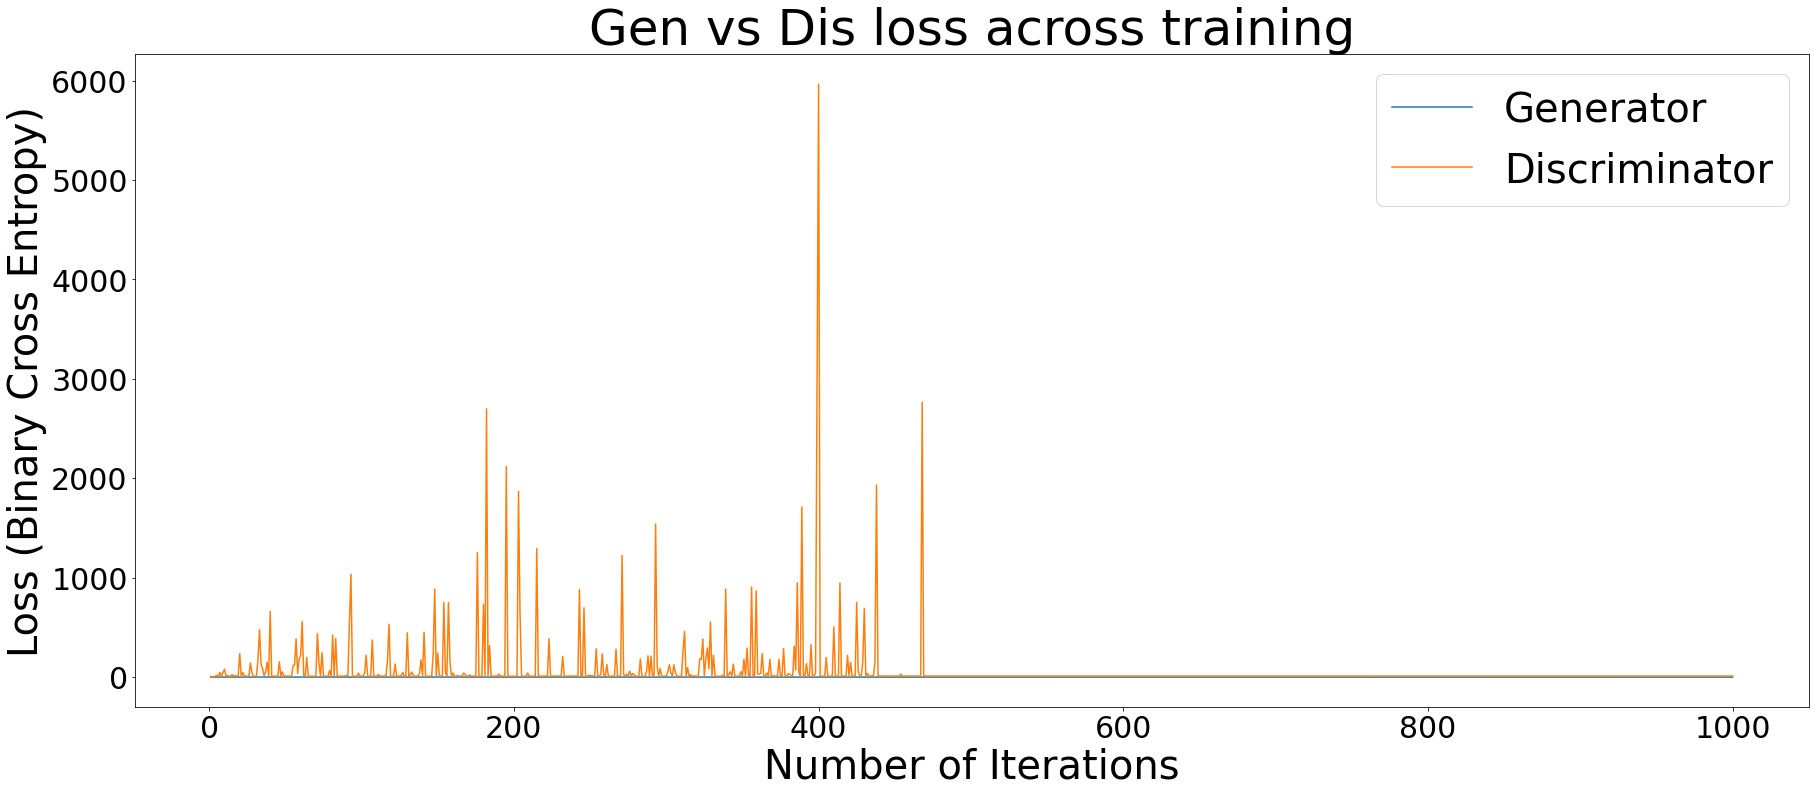

In [41]:
losses_g, losses_d = history[0], history[1]

fig, axes = plt.subplots(1,1, figsize=(30, 12))
ax1 = plt.subplot(1,1,1)

plt.plot(range(1,1001), losses_g, label = 'Generator')
plt.plot(range(1,1001), losses_d, label = 'Discriminator')
#plt.plot(range(1,601), losses_g, label = 'Generator')
#plt.plot(range(1, 601), losses_d, label = 'Discriminator')

ax1.tick_params(labelsize = 30)
ax1.set_xlabel('Number of Iterations', fontsize = 40)
ax1.set_ylabel('Loss (Binary Cross Entropy)', fontsize = 40)
plt.title('Gen vs Dis loss across training', fontsize = 50)
plt.legend(fontsize = 40)

# Testing Generated Samples from Trained Generator

In [42]:
#df.label.value_counts()

In [43]:
def generate_samples(number_of_samples_to_generate, class_val):
    if class_val == 0:
        label = torch.zeros(number_of_samples_to_generate, dtype=torch.int).to(device)  #generate for class 0
    elif class_val == 1:
        label = torch.ones(number_of_samples_to_generate, dtype=torch.int).to(device)  #generate for class 1
        
        
    latent_space_samples = torch.randn(number_of_samples_to_generate, n_features).to(device)
    generated_samples = generator(latent_space_samples, label)
#     print('generated_samples: ', generated_samples.shape)
#     print('label: ', label.shape)
    generated_samples = torch.concat([generated_samples, label.reshape(number_of_samples_to_generate, 1)], \
                                     dim = 1)
    generated_samples = generated_samples.cpu().detach().numpy()
    df_generated = pd.DataFrame(generated_samples, columns = df.columns)  #assign columns
    #df_generated = pd.DataFrame(generated_samples)  # don't assign columns, leon
    return df_generated

In [44]:
#df_generated_0 = generate_samples(549, 0)
df_generated_0 = generate_samples(2000, 0)  #5000
df_generated_0["diagnosis_result"] = 0
df_generated_0.info()
df_generated_0.head()
print(df_generated_0.head())
#df_generated_1 = generate_samples(342, 1)
df_generated_1 = generate_samples(2000, 1)  #4800
df_generated_1["diagnosis_result"] = 1
print(df_generated_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   diagnosis_result  2000 non-null   int64  
 1   radius            2000 non-null   float32
 2   area              2000 non-null   float32
 3   smoothness        2000 non-null   float32
 4   compactness       2000 non-null   float32
 5   symmetry          2000 non-null   float32
dtypes: float32(5), int64(1)
memory usage: 54.8 KB
   diagnosis_result    radius      area  smoothness  compactness  symmetry
0                 0 -1.889431  1.203892    0.988431     0.024688       0.0
1                 0 -0.552276  1.076713    1.381910     0.447033       0.0
2                 0  0.208751 -0.895304    0.779617    -1.514724       0.0
3                 0  0.033479  0.284522    0.826339     0.437800       0.0
4                 0 -0.325401 -0.242559    0.574375    -0.895817       0.0
   diagnosis_resu

Concatenate dataset

In [45]:
df_gan = pd.concat([df_generated_1, df_generated_0], ignore_index=True, sort=False)  #leon
df_gan = df_gan.sample(frac=1).reset_index(drop=True)  #用于从DataFrame中随机选择行和列。

y_train_gan = df_gan['diagnosis_result']
X_train_gan = df_gan.drop('diagnosis_result',axis='columns')
#print(X_train_2.iloc[0:5])pe
#y_train_gan = df_gan['LUNG_CANCER'].values
#y_train_gan = df_gan['LUNG_CANCER']
print("X:", X_train_gan.head())
print("Y：", y_train_gan.head())



#y_train_2_d = df_gan['LUNG_CANCER']

#transform to narray lost column name
X_train_gan = X_train_gan.values
y_train_gan = y_train_gan.values
#transforms to dataframe again
X_train_gan = pd.DataFrame(X_train_gan)
y_train_gan = pd.DataFrame(y_train_gan)

print(f"X_train_gan shape: {X_train_gan.shape}")
print(f"y_train_gan shape: {y_train_gan.shape}")

# transform and lost column name for concatenation
# origin_df_x = pd.DataFrame(X_train.values)
# origin_df_y = pd.DataFrame(y_train.values)
origin_df_x = pd.DataFrame(X_train)
origin_df_y = pd.DataFrame(y_train.values)


#X_train_2_e =  X_train_2.values

#origin_df - pd.merge(origin_df_x,origin_df_y)
#origin_df.info()
#origin_df.head()

#X_train_2_d = pd.DataFrame(X_train_2_e)

X_train_fin = pd.concat([origin_df_x, X_train_gan], axis=0, ignore_index=True)       
y_train_fin = pd.concat([origin_df_y, y_train_gan], axis=0, ignore_index=True)
print('X', X_train_fin.count())
print('y:',y_train_fin.count())
print('X', X_train_fin.shape)
print('y:',y_train_fin.shape)


#print("y count(）", y_train_fin.value_counts())
print(X_train_fin.head())
print(y_train_fin.head())

X:      radius      area  smoothness  compactness  symmetry
0 -1.287320 -1.156069   -0.681620    -1.605024       1.0
1  0.275186 -1.622920    0.191419    -1.753841       0.0
2 -1.249695 -0.857896   -0.553704    -1.404824       1.0
3 -1.592028  0.421847    0.521748    -0.858297       0.0
4  0.426334 -0.285844    1.500496    -1.006848       0.0
Y： 0    1
1    0
2    1
3    0
4    0
Name: diagnosis_result, dtype: int64
X_train_gan shape: (4000, 5)
y_train_gan shape: (4000, 1)
X 0    4070
1    4070
2    4070
3    4070
4    4070
dtype: int64
y: 0    4070
dtype: int64
X (4070, 5)
y: (4070, 1)
          0         1         2         3         4
0 -1.173784  1.163452 -0.916925  1.361315  1.224222
1 -0.156892  0.173675  0.037768  0.325711  0.194148
2  1.673514 -1.039385 -0.476297 -1.055095  0.459973
3  1.673514 -1.056048 -1.504428 -1.449611 -0.237819
4 -1.377162  0.383628 -0.549735 -0.035929 -0.138134
   0
0  0
1  0
2  1
3  1
4  0


In [46]:
"""
import xgboost as xgb2
xgb2 = xgb2.XGBClassifier()
y_train_fin = y_train_fin.values.ravel()

xgb2.fit(X_train_fin,y_train_fin)

y_pred = xgb2.predict(X_test)

print(classification_report(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))
plot_confusion_matrix(xgb2, X_test, y_test)
plt.show()  
"""

'\nimport xgboost as xgb2\nxgb2 = xgb2.XGBClassifier()\ny_train_fin = y_train_fin.values.ravel()\n\nxgb2.fit(X_train_fin,y_train_fin)\n\ny_pred = xgb2.predict(X_test)\n\nprint(classification_report(y_test, y_pred))\nprint(classification_report_imbalanced(y_test, y_pred))\nplot_confusion_matrix(xgb2, X_test, y_test)\nplt.show()  \n'

In [47]:
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), param_grid = parameter, 
                             scoring='accuracy', n_jobs=-1, cv=2)

p_grid_search.fit(X_train_fin,y_train_fin)


GridSearchCV(cv=2,
             estimator=xgb.XGBClassifier(base_score=None, booster=None,   #leon  add xgb before xgbclassifier
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=None, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 5, 2)},
             scoring='accuracy')

p_grid_search.best_params_, p_grid_search.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.991891891891892)

In [48]:
refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                                      min_child_weight=list(p_grid_search.best_params_.values())[-1]+4)
refined_xgb_model.fit(X_train_fin,y_train_fin)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

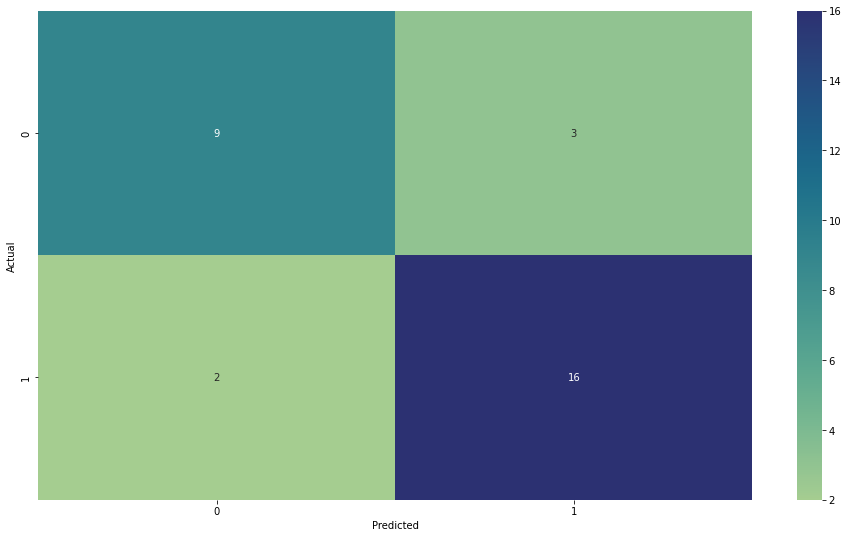

              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.84      0.89      0.86        18

    accuracy                           0.83        30
   macro avg       0.83      0.82      0.82        30
weighted avg       0.83      0.83      0.83        30

                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.75      0.89      0.78      0.82      0.66        12
          1       0.84      0.89      0.75      0.86      0.82      0.68        18

avg / total       0.83      0.83      0.81      0.83      0.82      0.67        30



In [49]:
#from imblearn.metrics import classification_report_imbalanced
ref_xgb_pred_y2 = refined_xgb_model.predict(X_test)
def plot_confusion_matrix(y_test, y_pred, color):
    
    plt.rcParams['figure.figsize'] = (16, 9)
   
    data = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                              rownames=['Actual'], 
                              colnames=['Predicted'])
    
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap=color)
    plt.show()
    
plot_confusion_matrix(np.array(y_test), ref_xgb_pred_y2, 'crest')
print(classification_report(y_test, ref_xgb_pred_y2))
print(classification_report_imbalanced(y_test, ref_xgb_pred_y2))  #, digits=4

In [50]:
"""
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf.fit(X_train_fin,y_train_fin)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf, X_test, y_test)
plt.show()
"""

'\nfrom sklearn.ensemble import RandomForestClassifier\nrf = RandomForestClassifier(n_estimators=300, n_jobs=-1)\nrf.fit(X_train_fin,y_train_fin)\ny_pred = rf.predict(X_test)\n\nprint(classification_report(y_test, y_pred))\nplot_confusion_matrix(rf, X_test, y_test)\nplt.show()\n'

              precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       0.93      0.78      0.85        18

    accuracy                           0.83        30
   macro avg       0.83      0.85      0.83        30
weighted avg       0.85      0.83      0.84        30

                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      0.92      0.78      0.81      0.84      0.72        12
          1       0.93      0.78      0.92      0.85      0.84      0.70        18

avg / total       0.85      0.83      0.86      0.84      0.84      0.71        30

[0 1]


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


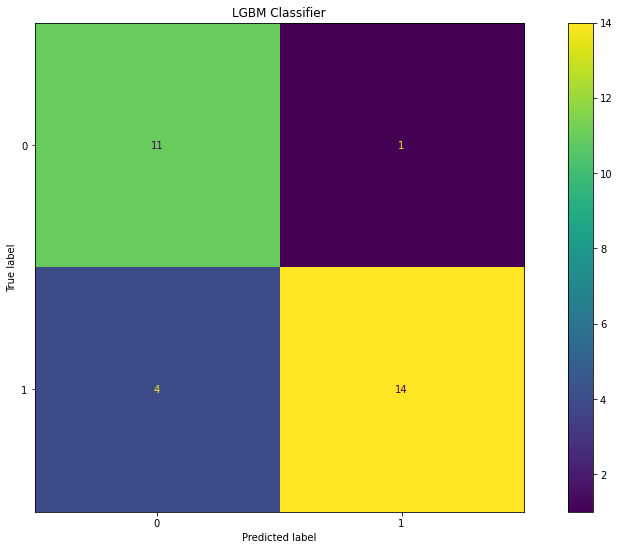

In [51]:
lgb_2 = lgb.LGBMClassifier()

#y_train_3 = y_train_3.values
#y_train_3 = y_train_3.ravel()
lgb_2.fit(X_train_fin,y_train_fin)

y_pred = lgb_2.predict(X_test)


print(classification_report(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))
"""
plot_confusion_matrix(lgb_2, X_test, y_test)
plt.show()
"""
print(lgb_2.classes_)

cm = confusion_matrix(y_test, y_pred, labels=lgb_2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_2.classes_)
disp.plot()
_ = disp.ax_.set_title("LGBM Classifier")
plt.show()

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.88      0.83      0.86        18

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30

                   pre       rec       spe        f1       geo       iba       sup

          0       0.77      0.83      0.83      0.80      0.83      0.69        12
          1       0.88      0.83      0.83      0.86      0.83      0.69        18

avg / total       0.84      0.83      0.83      0.83      0.83      0.69        30



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


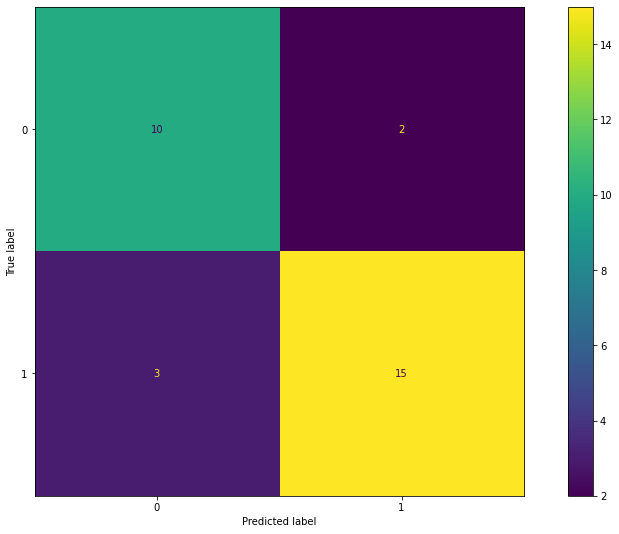

In [52]:
import xgboost as xgb
from sklearn.metrics import classification_report,\
                            plot_confusion_matrix, confusion_matrix
xgb_3=xgb.XGBClassifier()

xgb_3.fit(X_train_fin, y_train_fin)

y_pred2 = xgb_3.predict(X_test)
#from sklearn.preprocessing import LabelEncoder
#change y value to 0..2
#le2 = LabelEncoder()
#y_test = le2.fit_transform(y_test)

print(classification_report(y_test, y_pred2))
print(classification_report_imbalanced(y_test, y_pred2)) 
plot_confusion_matrix(xgb_3, X_test, y_test)
plt.show()

# Checking distributions of synthetic data

In [53]:
"""
import warnings
warnings.filterwarnings("ignore")
"""

'\nimport warnings\nwarnings.filterwarnings("ignore")\n'

In [54]:

"""
df0 = df[df.LUNG_CANCER == 0]
#df1 = df[df.label == 1]
df1 = df[df.LUNG_CANCER == 1]

mc = MinMaxScaler(feature_range=(0, 1))
standard_scaler0 = mc.fit(df0)
df0 = standard_scaler0.transform(df0)
#x_scaled = pd.DataFrame(df0)

standard_scaler1 = mc.fit(df1)
df1 = standard_scaler1.transform(df1)

print(df0[0:5])
print(df1[0:5])
"""

'\ndf0 = df[df.LUNG_CANCER == 0]\n#df1 = df[df.label == 1]\ndf1 = df[df.LUNG_CANCER == 1]\n\nmc = MinMaxScaler(feature_range=(0, 1))\nstandard_scaler0 = mc.fit(df0)\ndf0 = standard_scaler0.transform(df0)\n#x_scaled = pd.DataFrame(df0)\n\nstandard_scaler1 = mc.fit(df1)\ndf1 = standard_scaler1.transform(df1)\n\nprint(df0[0:5])\nprint(df1[0:5])\n'

<b> For class 0

In [55]:
"""
print('FOR CLASS 0')
fig, axes = plt.subplots(16, 1, figsize=(10, 50))  # must change plot number

for n, col in enumerate(df.columns.to_list()[:-1]):
    ax1 = plt.subplot(16,1, n+1)  # must change plot number
    sns.distplot(x = df_generated_0[col], color = 'red', label = 'Generated')
    sns.distplot(x = df0[col], color = 'blue', label = 'real')
    plt.legend(fontsize = 12)  # 30
    plt.xlabel(col, fontsize = 12)  #30 
    plt.title(col, fontsize = 12)   #30
    plt.ylabel(' ')
plt.subplots_adjust(wspace=0.5,hspace=0.5)
"""

"\nprint('FOR CLASS 0')\nfig, axes = plt.subplots(16, 1, figsize=(10, 50))  # must change plot number\n\nfor n, col in enumerate(df.columns.to_list()[:-1]):\n    ax1 = plt.subplot(16,1, n+1)  # must change plot number\n    sns.distplot(x = df_generated_0[col], color = 'red', label = 'Generated')\n    sns.distplot(x = df0[col], color = 'blue', label = 'real')\n    plt.legend(fontsize = 12)  # 30\n    plt.xlabel(col, fontsize = 12)  #30 \n    plt.title(col, fontsize = 12)   #30\n    plt.ylabel(' ')\nplt.subplots_adjust(wspace=0.5,hspace=0.5)\n"

<b> For class 1

In [56]:
"""
print('FOR CLASS 1')
fig, axes = plt.subplots(16, 1, figsize=(10, 50)) #must change font size 

for n, col in enumerate(df.columns.to_list()[:-1]):
    ax1 = plt.subplot(16,1, n+1)
    sns.distplot(x = df_generated_1[col], color = 'red', label = 'Generated')
    sns.distplot(x = df1[col], color = 'blue', label = 'real')
    plt.legend(fontsize = 12) # #30
    plt.xlabel(col, fontsize = 12)
    plt.title(col, fontsize = 12)
    plt.ylabel(' ')
plt.subplots_adjust(wspace=0.5,hspace=0.5)
"""

"\nprint('FOR CLASS 1')\nfig, axes = plt.subplots(16, 1, figsize=(10, 50)) #must change font size \n\nfor n, col in enumerate(df.columns.to_list()[:-1]):\n    ax1 = plt.subplot(16,1, n+1)\n    sns.distplot(x = df_generated_1[col], color = 'red', label = 'Generated')\n    sns.distplot(x = df1[col], color = 'blue', label = 'real')\n    plt.legend(fontsize = 12) # #30\n    plt.xlabel(col, fontsize = 12)\n    plt.title(col, fontsize = 12)\n    plt.ylabel(' ')\nplt.subplots_adjust(wspace=0.5,hspace=0.5)\n"

Asssessment